## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
earlystop = [10,25]

In [14]:
results = {}

for i in earlystop:
    keras.backend.clear_session()
    earlystop = EarlyStopping(monitor = 'val_loss',patience = i,verbose = 1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    name = 'earlystop - %s' %(i)
    results[name] = {
        'train_loss':train_loss,
        'valid_loss':valid_loss,
        'train_acc':train_acc,
        'valid_acc':valid_acc
    }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 9/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3419 - acc: 0.5323 - val_loss: 1.5015 - val_acc: 0.4732
Epoch 10/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3121 - acc: 0.5440 - val_loss: 1.4870 - val_acc: 0.4745s - loss: 1.3105 - acc: 0
Epoch 11/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2844 - acc: 0.5536 - val_loss: 1.4808 - val_acc: 0.4804 - loss: 1.2864 - acc: 0.
Epoch 12/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.2586 - acc: 0.5627 - val_loss: 1.4650 - val_acc: 0.4823
Epoch 13/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2322 - acc: 0.5743 - val_loss: 1.4693 - val_acc: 0.4856
Epoch 14/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.2093 - acc: 0.5825 - val_loss: 1.4671 - val_acc: 0.4814- loss: 1.2144 
Epoch 15/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.1855 - acc: 0.5914 - val_l

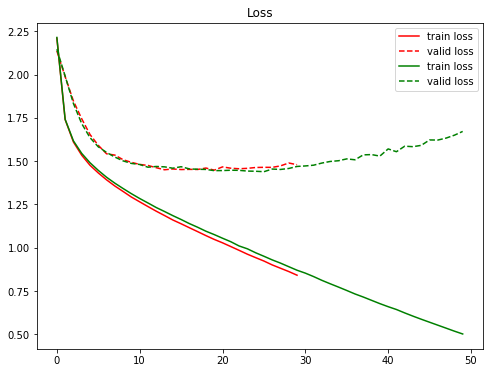

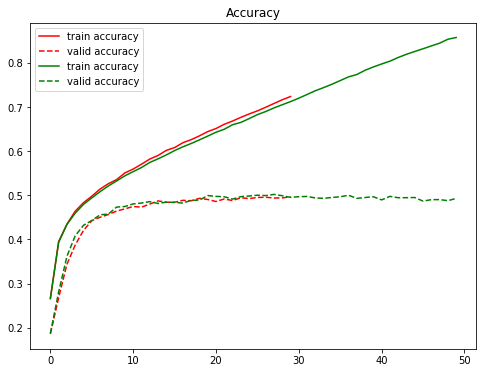

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['r','g']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'],"-" ,label="train loss",color = color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'],"--", label="valid loss",color = color_bar[i])

plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-',label="train accuracy",color = color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--',label="valid accuracy",color = color_bar[i])
plt.legend()
plt.title("Accuracy")
plt.show()